In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


In [18]:
df = pd.read_csv(r"C:\Users\klvkl\income-category-prediction\data\adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [19]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
numerical_features = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

X = df[numerical_features]
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV  

In [22]:
log_reg = LogisticRegression(max_iter=2000, random_state=42)

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': [None, 'balanced']
}

log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

grid_search_lr = GridSearchCV(log_reg_pipeline, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

print("Logistic Regression - Best Params:", grid_search_lr.best_params_)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression - Best Params: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8151831592905685
[[4325  206]
 [ 909  593]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4531
           1       0.74      0.39      0.52      1502

    accuracy                           0.82      6033
   macro avg       0.78      0.67      0.70      6033
weighted avg       0.81      0.82      0.79      6033



In [23]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [24]:
decision_tree = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', decision_tree)
])

grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

print("Decision Tree - Best Params:", grid_search_dt.best_params_)
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree - Best Params: {'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5}
Decision Tree - Accuracy: 0.8337477208685563
[[4361  170]
 [ 833  669]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4531
           1       0.80      0.45      0.57      1502

    accuracy                           0.83      6033
   macro avg       0.82      0.70      0.73      6033
weighted avg       0.83      0.83      0.82      6033



In [25]:
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [26]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', random_search)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Accuracy: 0.8445217967843527
[[4345  186]
 [ 752  750]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4531
           1       0.80      0.50      0.62      1502

    accuracy                           0.84      6033
   macro avg       0.83      0.73      0.76      6033
weighted avg       0.84      0.84      0.83      6033



In [27]:
print("Best XGBoost Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_tuned))
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))


Best XGBoost Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV Score: 0.8377471092875792
Tuned XGBoost Accuracy: 0.7742416708105421
[[4349  182]
 [1180  322]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      4531
           1       0.64      0.21      0.32      1502

    accuracy                           0.77      6033
   macro avg       0.71      0.59      0.59      6033
weighted avg       0.75      0.77      0.73      6033



In [28]:
joblib.dump(pipeline, "xgboost_best_model.pkl")


['xgboost_best_model.pkl']

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],  
    'classifier__max_depth': [None, 10, 20, 30], 
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4],   
    'classifier__class_weight': [None, 'balanced'] 
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', random_forest)
])

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest - Best Params:", grid_search_rf.best_params_)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest - Best Params: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Random Forest - Accuracy: 0.8383888612630532
[[4348  183]
 [ 792  710]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4531
           1       0.80      0.47      0.59      1502

    accuracy                           0.84      6033
   macro avg       0.82      0.72      0.75      6033
weighted avg       0.83      0.84      0.82      6033



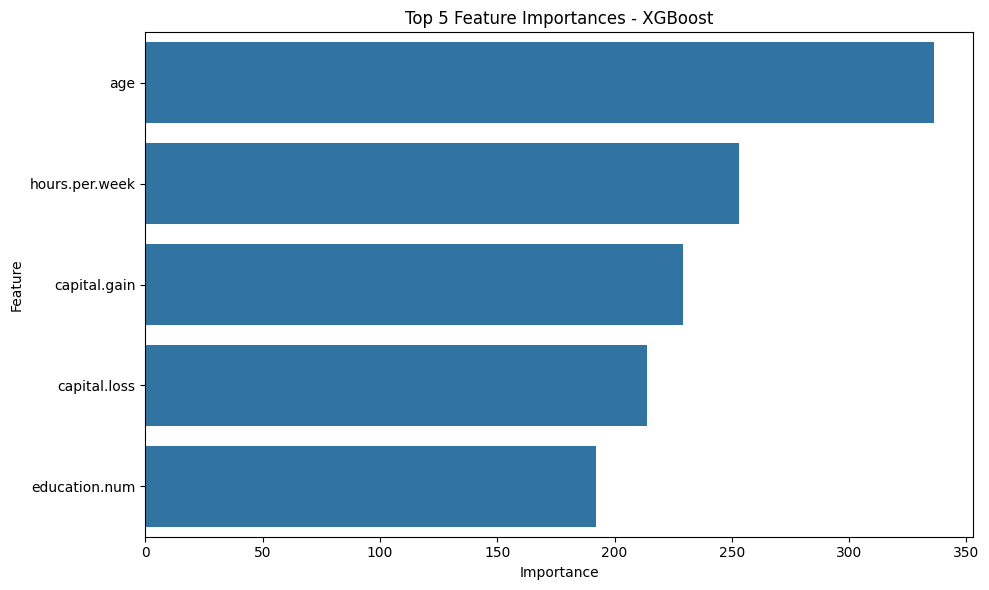

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

best_xgb_model = random_search.best_estimator_  
importances = best_xgb_model.get_booster().get_score(importance_type='weight')
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importances.keys()],
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title("Top 5 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

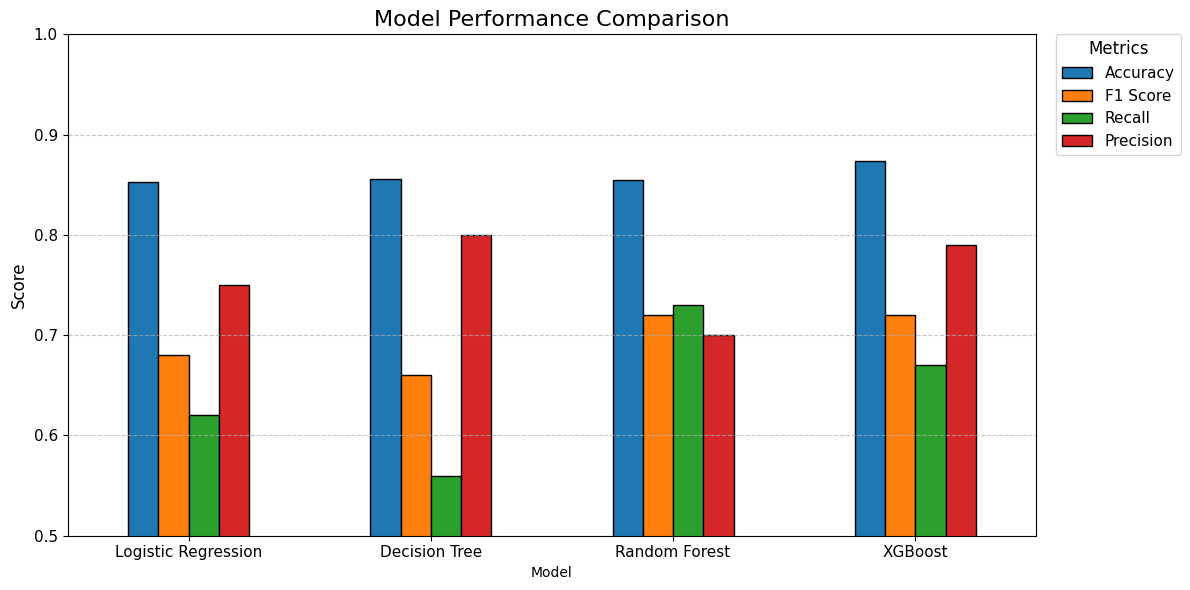

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = [0.853, 0.856, 0.855, 0.874]
f1_scores = [0.68, 0.66, 0.72, 0.72]
recalls = [0.62, 0.56, 0.73, 0.67]
precisions = [0.75, 0.80, 0.70, 0.79]

metrics_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "F1 Score": f1_scores,
    "Recall": recalls,
    "Precision": precisions
})

plt.figure(figsize=(12, 6))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 6), edgecolor="black")

plt.title("Model Performance Comparison", fontsize=16)
plt.ylim(0.5, 1.0) 
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1.02, 1), 
    borderaxespad=0,
    title='Metrics', 
    title_fontsize=12, 
    fontsize=11
)
plt.tight_layout()
plt.show()


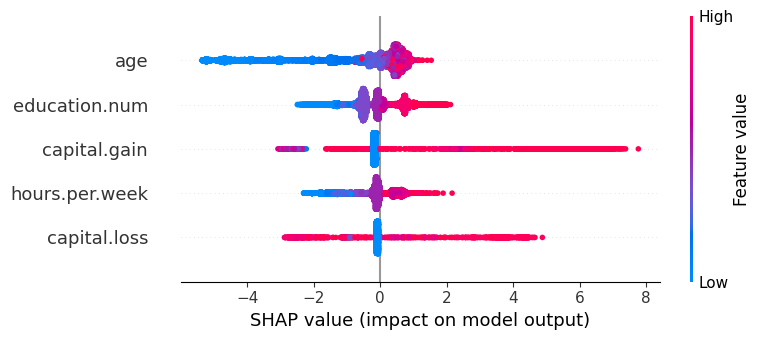

In [37]:
from sklearn.preprocessing import StandardScaler
import shap 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)
